# LVM Data Simulator tutorial

This is a tutorial to install and use the LVM Data Simulator - Created 2022/03/24

2022/05/18 - New section showing how to use dictionaries to run the simulator. Bug fixes

## Installation and setup

### Installing the package

The package can be found on github at this link: https://github.com/sdss/lvmdatasimulator

First clone the package with:

```git clone --recursive https://github.com/sdss/lvmdatasimulator```
    
then move into the package directory and install it with ```python -m pip install -e .```. Pip should automatically install all the dependencies needed for the simulator to work (if not, let us know!)

### Downloading libraries

Once the package is installed, you have to download two files that are temporarily stored in an FTP server at Universidad de Chile.

To download them you should run the following commands and move the files in the ```lvmdatasimulator/data``` directory:

```wget ftp@ftp.das.uchile.cl:/pub/enrico/LVM_cloudy_sphere_models.fits```

```wget ftp@ftp.das.uchile.cl:/pub/enrico/pollux_resampled_v0.fits```

*Note: third file file with precalculated continuum models is not ready now, just ignore the corresponding warning when importing lvmdatasimulator*

At this point, everything should be ready to go. We just want to highlight that this is still a work-in-progress, and in the future how the simulator is called could change significantly. The goal is to write a main.py script able to read a configuration file.

**N.B.: This notebook should run just fine once you download and install the package. However, we suggest to move it to a different, empty directory, where it will be possible to save all the files produced during the test.**

### Adjust config file

Currently, there is a configuration file where you might want to setup a few variables. You can find this file here:
```ROOT_DIR/python/lvmdatasimulator/etc/lvmdatasimulator.yml```, where ```ROOT_DIR``` is the directory where you have installed the package. 

In this config you may want to adjust:
* Maximal number of cores to use in calculations (default = 8)
* Working directory (work_dir) where all outputs and intermediate files produced by simulator will be saved. By default, this is the current directory. 

You can also change the working directory from this notebook by using the os package as follows:

In [1]:
import os
# os.chdir('/directory/where/I/want/to/save/all/files/')
os.chdir('/mnt/DATA/LVM/Useful_data/test_notebooks')

Changing the work_dir in the configuration file, or changing the current directory is NOT needed if you move the notebook to an empty folder.

## Part 1: simulating the target field

The first step to perform the simulations is to create a field to be observed. Once the field is created, all its components can be saved to fits files and used again in future runs.

We first need to import all the necessary modules needed for the simulations:

In [2]:
import astropy.units as u
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

Then, we need to setup the LVM field object:

In [3]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, spaxel=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_spaxel=u.arcsec, name='LVM_test')

This line initializes the LVMField object. The needed inputs are:
- ra, dec: coordinates of the field to be observed. Used to build the WCS object
- size: size of the field to simulate
- spaxel: size of the spaxel
- unit_ra, unit_dec: unit used for the coordinates of the field, defaults to degrees
- unit size: unit of the size argument. defaults to arcmin
- unit_spaxel: unit of the spaxels, defaults to arcsec
- name: name of the field. It will be used to define the names of the output files.

It must be noticed that the size of the field now is only 15 armin. At this point, simulating the full LVM FOV is still not possible, unless the simulator is running on a computer with significant amounts of RAM (> 30 GB, but actual minimum limit not determined yet).

The object is still empty, we need to generate the targets of the simulations. There are two types iof targets that can be simulated: **stars** and **nebulae**.

**Stars** are simulated by searching the GAIA catalog for stars brighter than a user defined limit. To each star we associate a spectrum, based on the estimated temperature of the object. All spectra are recovered from the pollux spectral library. **The library is missing spectra with temperature between xxxx and xxxx degrees. Stellar spectra should only be used for signal-to-noise ratio estimates, not to recover physical quantities**.

The stellar component is created as following:

In [4]:
my_lvmfield.generate_gaia_stars(gmag_limit=18)

[INFO]: 139 Gaia stars in the field
[INFO]: 101 stars are fainter than 18 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
 55% (21 of 38) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00

INFO: Query finished. [astroquery.utils.tap.core]


100% (38 of 38) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 38 synthetic spectra.
[INFO]: Saving star list to: ./LVM_test_starlist.fits.gz
[WARNING]: The file ././LVM_test_starlist.fits.gz already exist and it will be overwritten


Once created, the star list is automatically saved to file, and it can be used to re-run the simulation without having to query GAIA again. The default position of this file is the current working directory, but it can be saved in another position by defining the *directory* argument. To read the saved file:

In [5]:
my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz')

[INFO]: Reading the star list from file ./LVM_test_starlist.fits.gz


The nebular component, on the other hand, contains a wide variety of different types of sources that can be created. While there are some core quantities shared among most types of sources, many need some type-specific keywords to be defined. For a complete view of the inputs needed for each kind of nebula, we refer to the code documentation.

The nebular component should be passed to the field object as a list of dictionaries. Each dictionary represent a single nebula. A simple example, where we simulate a bubble + a diffuse gas component, can be found here:

In [6]:
my_nebulae = [
              {"type": 'Bubble', 'expansion_velocity': 10 * u.km/u.s,
               'turbulent_sigma': 20 * u.km/u.s,
               'radius': 15 * u.pc,
               'max_brightness': 1e-16 * u.erg / u.cm**2 / u.s / u.arcsec ** 2,
               'RA': '00h39m40s', 'DEC': "-10d02m13s",
               'cloudy_params': {'Z': 0.6, 'qH': 49., 'nH': 30, 'Teff': 30000, 'Rin': 0},
               'perturb_amplitude': 0.4, 'perturb_order': 8},
              {"type": 'DIG', 'max_brightness': 1e-17 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
               'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc}
              ]

To include the nebulae in the LVMField object we can use:

In [7]:
my_lvmfield.add_nebulae(my_nebulae, save_nebulae="testneb_v3.fits")

[INFO]: Start generating 2 nebulae
 50% (1 of 2) |#############             | Elapsed Time: 0:00:53 ETA:   0:00:53[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #1: use default 'cloudy_id=983'
100% (2 of 2) |##########################| Elapsed Time: 0:00:56 Time:  0:00:56
[INFO]: Generated ISM saved to ./testneb_v3.fits


The nebulae will be saved to file, so that they can be reused for other simulations without having to generate them. To read the nebulae from file:

In [8]:
my_lvmfield.add_nebulae(load_from_file="testneb_v3.fits")

[INFO]: Nebulae successfully loaded from file


**Note: if you want to modify the parameters of stars/nebulae, you have to initialize LVMField again as otherwise its content will be dublicated. This bug will be fixed soon**

 ## Part 2: Setting up the simulator


At this point the Field is ready to be observed. We are still missing, however, the complete instrument setup. The instrument is composed by a **telescope**, a **spectrograph** and a **fiber bundle**. To create the elements we just need to generate the objects as follows:

In [9]:
tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='central', nrings=4, angle=0, custom_fibers=None)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using only the central fiber.
[INFO]: Using the inner 4 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


So far, we support a single telescope object LVM160() and a single spectrograph configuration LinearSpectrograph(). The latter, in particular, is a spectrograph with a 3650-9800 A wavelength range, and a constant 0.5 A dispersion.

The fiber bundle, on the other hand is already pretty configurable. The array is built as a series of concentric hexagonal rings, and within the ring each fiber has a unique ID. Using therefore two numbers (the ring number and the fiber position) it is possible to univocally identify each fiber. Using this identification system it is possible to build a wide variety of fiber configurations. The one supported so far are:
- central: simulate only the central fiber
- full: simulate the full hexagonal array
- horizontal: simulate an horizontal line of fibers
- diagonals: simulate the main diagonals of the hexagons

the nrings argument can be used to limit how many fiber are going to be simulated. In particular, if nrings is not none, each different configuration except for "central" is simulated up to the fibers included in the hexagonal ring nrings.  

Here we there is an example of a "full" bundle with nrings=5

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


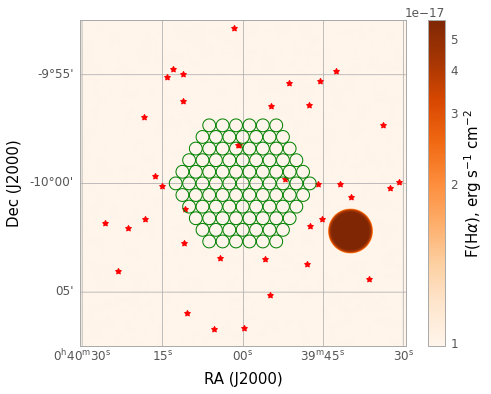

In [10]:
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='full_5.png')


Then, we have an example of a "diagonals" array with nrings=5 and nrings=9

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


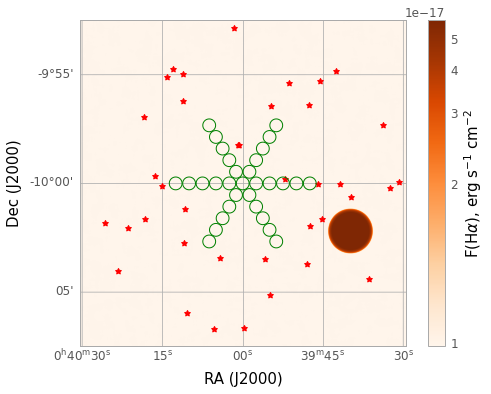

In [11]:
bundle = FiberBundle(bundle_name='diagonals', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='diagonals_5.png')

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 9 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


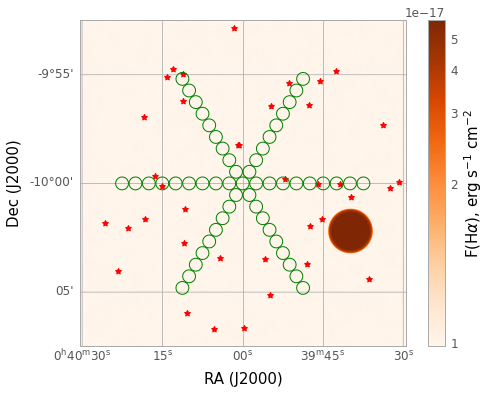

In [12]:
bundle = FiberBundle(bundle_name='diagonals', nrings=9, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='diagonals_9.png')

Finally, an example of an "horizontal" array

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


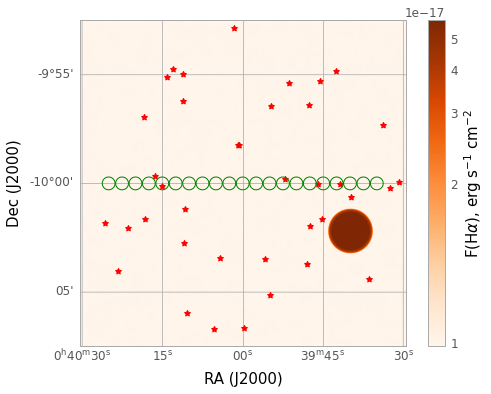

In [13]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='horizontal_10.png')

Fiber bundles can also be rotatet with the "angle" argument. The rotations proceeds counter clockwise. 

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 45 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


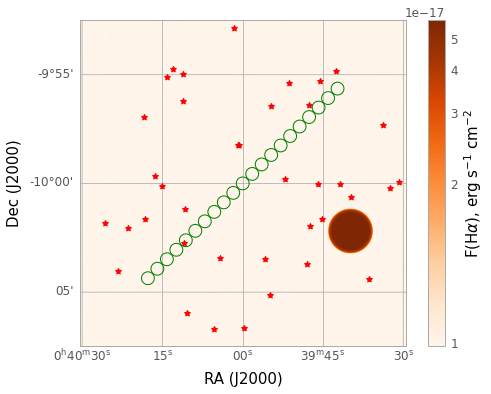

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


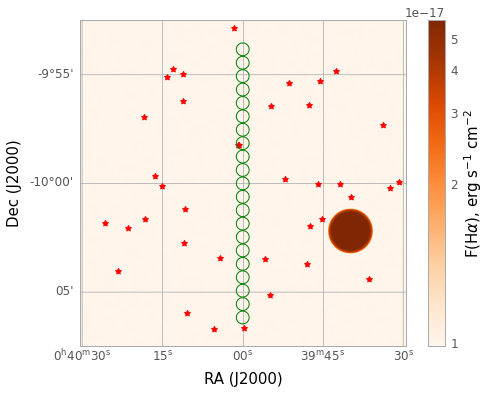

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.
[WARNING]: Bundle center coords are not defined, using the coords of the field.


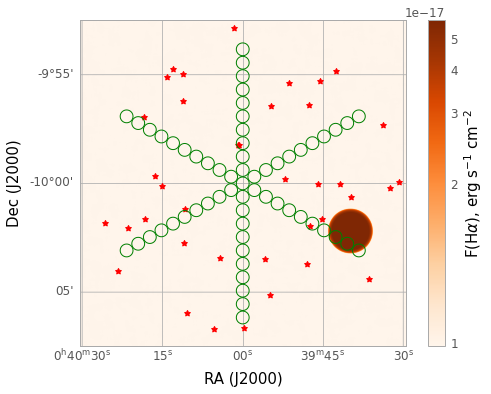

In [14]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=45, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='horizontal_10_45.png')

bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='horizontal_10_90.png')

bundle = FiberBundle(bundle_name='diagonals', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='diagonals_10_90.png')

The last step before running the simulator is to define the properties of the observations by initializing the **Observation** object. This object requires the coordinates of the field to be observed, their units of measurement and a list of exposure times. Multiple exposure times can be simulated during a single run of the simulator. Finally, there are a few other optional parameters that can be used to modify the properties of the observations. These parameters are:

- time (e.g. '2022-01-01T00:00:00.00'),
- utcoffset,
- exptimes,
- airmass,
- days_moon,
- sky_template.

As a default, time, utcoffset and the bundle center coordinates will be used to determine the lunar phase (and the sky brightness) and the airmass of the target during the observations. However, the airmass of the target can be manually provided, as well as the moon phase (using the days_moon parameter). If the latter is provided, the sky template will be selected according to the moon phase. Finally, a completely custom sky template can be used by providing the path to the file using the sky_template parameter.


In [15]:
obs = Observation(ra=10, dec=-10, unit_ra=u.deg, unit_dec=u.deg, exptimes=[24*900])


## Part 3: running the simulator

Now we are ready to perform the simulation. First we initialize the simulator, giving it as an input all the things we already initialized:

In [16]:
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Them we can perform the simulations and save the outputs:

In [17]:
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570], unit_range=u.AA)

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 61 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Dividing the array in 4 chunks
[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
 50% (1 of 2) |#############             | Elapsed Time: 0:00:28 ETA:   0:00:28[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole 

Multiple images can be produced at the same time, by providing a list of wavelength ranges to be integrated.

# Part 4: running the simulator - easy version

If the user do not want to manually setup the simulations, we prepared a small script that accepts as an input a dictionary which contains all the parameters needed to produce the simulations. If a parameter is not present in the dictionary, a default value will be used. To take advantage of this new approach, first we need to import the script and the astropy units package:

In [18]:
from lvmdatasimulator.run import run_simulator_1d

import astropy.units as u

Then, we have to prepare a list with all the nebulae that should be simulated.

In [19]:
my_nebulae = [
              {"type": 'Bubble', 'expansion_velocity': 10 * u.km/u.s,
               'turbulent_sigma': 20 * u.km/u.s,
               'radius': 15 * u.pc,
               'max_brightness': 1e-16 * u.erg / u.cm**2 / u.s / u.arcsec ** 2,
               'RA': '00h39m40s', 'DEC': "-10d02m13s",
               'cloudy_params': {'Z': 0.6, 'qH': 49., 'nH': 30, 'Teff': 30000, 'Rin': 0},
               'perturb_amplitude': 0.4, 'perturb_order': 8},
              {"type": 'DIG', 'max_brightness': 1e-17 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
               'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc}
              ]


In this case we are simulating the same field described in Part 1 of this tutorial. If a source field is already available, it is possible to use it by providing its name in the dictionary using the ```nebulae_from_file``` keyword.

Then, we need to setup the dictionary as follows:

In [20]:
parameters = dict(
                  # LVMField inputs
                  ra=10,  # RA of the source field
                  dec=-10,  # DEC of the source field
                  size=15,  # size of the source field
                  spaxel=1,  # spaxel size of the source field
                  unit_ra=u.degree,  # unit of RA
                  unit_dec=u.degree,  # unit of DEC
                  unit_size=u.arcmin,  # unit of size
                  unit_spaxel=u.arcsec,  # unit of spaxel
                  name='LVM_test',  # name of the field

                  # Nebulae generation
                  nebulae=my_nebulae,  # list of dictionaries defining the nebulae in the field
                  nebulae_name="testneb_v3.fits",  # name of the output source field file

                  # Star list generation
                  gmag_limit=18,  # maximum magnitude of gaia stars to include in the field

                  # save input/output map
                  wavelength_ranges=[[6550, 6570]],  # wavelength ranges to integrate for the input and output maps
                  unit_range=u.AA,  # units of measurement of the wavelength ranges

                  # parameters of Observation
                  ra_bundle=10,  # RA of the center of the bundle
                  dec_bundle=-10,  # DEC of the center of the bundle
                  unit_ra_bundle=u.deg,  # unit of ra_bundle
                  unit_dec_bundle=u.deg,  # unit of dec_bundle
                  exptimes=[24*900],  # list of exposure times in s

                  # bundle properties
                  bundle_name='full',  # type of fiber configuration
                  nrings=10,  # number of rings to simulate
                  angle=0,  # rotation to apply to the bundle.

                  # parameters of the simulator
                  fast=True  # use normal interpolation or precise resampling.
)

This dictionary will setup exactly the same configuration we simulate before during this tutorial, with the exception of the bundle, which will be in a 10 rings "full" configuration.

It is possible now to run the simulator as follows:

In [21]:
run_simulator_1d(parameters)

[INFO]: Start generating 2 nebulae
 50% (1 of 2) |#############             | Elapsed Time: 0:00:45 ETA:   0:00:45[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #1: use default 'cloudy_id=983'
100% (2 of 2) |##########################| Elapsed Time: 0:00:47 Time:  0:00:47
[INFO]: Generated ISM saved to ./testneb_v3.fits
[INFO]: 139 Gaia stars in the field
[INFO]: 101 stars are fainter than 18 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
 26% (10 of 38) |######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

INFO: Query finished. [astroquery.utils.tap.core]


100% (38 of 38) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 38 synthetic spectra.
[INFO]: Saving star list to: ./LVM_test_starlist.fits.gz
[WARNING]: The file ././LVM_test_starlist.fits.gz already exist and it will be overwritten


[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_test_6550_6570_input_map.fits
[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 331 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Dividing the array in 4 chunks
[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
 50% (1 of 2) |#############             | Elapsed Time: 0:00:3

Elapsed time: 295.7
